In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linearPolicy import linearPolicyLearner
from tree import treeNode, treeLearner
import pickle
from tqdm.auto import trange,tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
data_df = pd.read_csv('../voting/clean_data/voting_data.csv')
print(data_df.columns)

Index(['Unnamed: 0', 'sex', 'yob', 'g2000', 'g2002', 'g2004', 'p2000', 'p2002',
       'votedav', 'dem', 'nov', 'aug', 'city', 'hh_size',
       'totalpopulation_estimate', 'percent_male', 'percent_female',
       'median_age', 'percent_under5years', 'percent_5to9years',
       'percent_10to14years', 'percent_15to19years', 'percent_20to24years',
       'percent_25to34years', 'percent_35to44years', 'percent_45to54years',
       'percent_55to59years', 'percent_60to64years', 'percent_65to74years',
       'percent_75to84years', 'percent_85yearsandolder',
       'percent_18yearsandolder', 'percent_21yearsandover',
       'percent_62yearsandover', 'percent_65yearsandover', 'percent_white',
       'percent_black', 'percent_amindian_alaskan', 'percent_asian',
       'percent_nativeandother', 'percent_other_nativeandother',
       'percent_hispanicorlatino', 'percent_race_other', 'median_income',
       'mean_income', 'employ_16', 'unemploy_16', 'unemploy_20to64',
       'employ_20to64', 'emplo

In [25]:
print(data_df.groupby('action').mean()['outcome'])
action_cost_map = {
    0: 0.3,
    1: 0.32,
    2: 0.34,
    3: 0.36,
    4: 0.38,
}
new_data_df = data_df.copy()
new_data_df['outcome'] = new_data_df['outcome'] - new_data_df['action'].map(action_cost_map)

action
0    0.303903
1    0.326484
2    0.329817
3    0.356550
4    0.390300
Name: outcome, dtype: float64


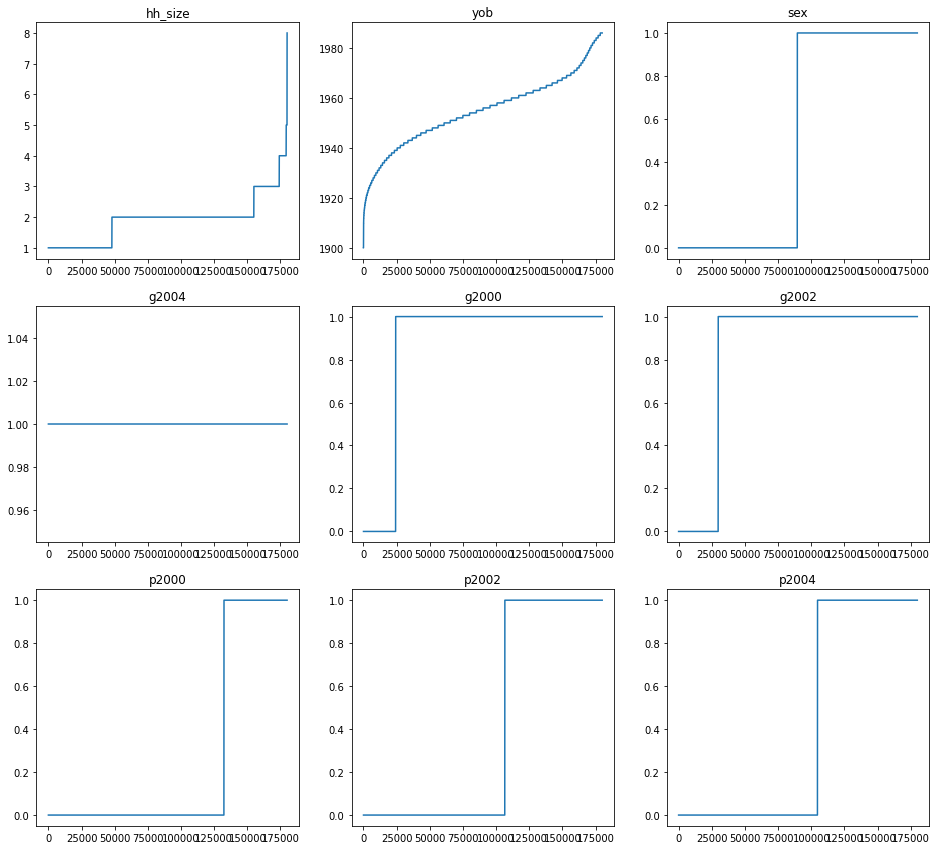

In [26]:
features_list = ['hh_size', 'yob', 'sex', 'g2004', 
                'g2000', 'g2002', 'p2000', 'p2002','p2004']
plt.figure(figsize=(16,20))
for i in range(len(features_list)):
    plt.subplot(4, 3, i+1)
    plt.title(features_list[i])
    plt.plot(np.sort(data_df[features_list].values[:,i]))

In [27]:
n, p = data_df.shape; p = p-2
data_df = new_data_df
features = data_df.iloc[:, 0:p]
features = features[features_list].values
actions = data_df.iloc[:, p].values
rewards = data_df.iloc[:, p+1].values
k = np.unique(actions).shape[0]
probs = np.array([10/18, 2/18, 2/18, 2/18, 2/18])

In [28]:
reward_IPW_mat = np.zeros((n,k))
reward_IPW_mat[np.arange(n), actions] = rewards / probs[actions]
rewards_mat = np.zeros((n,k))
rewards_mat[np.arange(n), actions] = rewards

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


<AxesSubplot:>

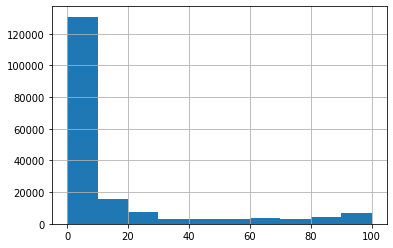

In [29]:
city_list = np.sort(data_df['city'].unique())
print(city_list)
data_df['city'].hist()

In [30]:
def city_cv_fold_generator(city_list):
    for city in city_list:
        idx_train = np.where(data_df['city'] != city)[0]
        idx_test = np.where(data_df['city'] == city)[0]
        yield city, (idx_train, idx_test)
        
for city, (idx_train, idx_test) in city_cv_fold_generator(city_list):
    print(city, (idx_train, idx_test))
    if city == 2:
        break

0 (array([     0,      1,      2, ..., 179999, 180000, 180001]), array([    13,     40,    121, ..., 179165, 179334, 179633]))
1 (array([     0,      2,      4, ..., 179998, 179999, 180001]), array([     1,      3,      6, ..., 179990, 179997, 180000]))
2 (array([     1,      3,      6, ..., 179999, 180000, 180001]), array([     0,      2,      4, ..., 179992, 179993, 179994]))


In [31]:
file_dir_str_fmt = './voting_tree_city_split_feature_new/model={model_name}_rs={random_seed:d}_cv={cv_fold:d}'
model_name = 'IPW_tree'; random_seed = 42
file_dir_str = file_dir_str_fmt.format(**{'model_name': model_name, 'random_seed': random_seed, 'cv_fold': 2, 'city': 0})
file_dir_str

'./voting_tree_city_split_feature_new/model=IPW_tree_rs=42_cv=2'

In [ ]:
from sklearn.model_selection import KFold
k_fold_idx_generator = KFold(n_splits = 5, random_state=42, shuffle=True).split(range(n))
DRO_file_dir_str_fmt = './voting_tree_city_split_feature_new/model={model_name}_rs={random_seed:d}_cv={cv_fold:d}_delta={delta:.3f}'
model_name = 'DRO_stable_tree'; random_seed = 42; delta = 0.1
for delta in tqdm(np.arange(0.01,0.41,0.01), leave=False):
    for k_fold, k_fold_idx in tqdm(city_cv_fold_generator(city_list[-1:]), total = 1):
        idx_train, idx_test = k_fold_idx
        features_train, features_test = features[idx_train,:], features[idx_test,:]
        actions_train, actions_test = actions[idx_train], actions[idx_test]
        rewards_train, rewards_test = rewards[idx_train], rewards[idx_test]
        rewards_mat_train, rewards_mat_test = rewards_mat[idx_train,:], rewards_mat[idx_test,:]
        reward_IPW_mat_train, reward_IPW_mat_test = reward_IPW_mat[idx_train], reward_IPW_mat[idx_test]
        actions_mat_train = (np.eye(k)[actions_train.astype(np.int)] / probs)
        tree_DRO_stable = treeLearner().DR_tree_learner_with_indicator(features_train, rewards_mat_train, 
                                                                       actions_mat_train, level_of_split=2, 
                                                                       delta = delta, alpha_init = 0.2,
                                                                       max_iter = 15,verbose=False)
        file_dir_str = DRO_file_dir_str_fmt.format(model_name=model_name, random_seed=random_seed, cv_fold=k_fold, delta = delta)
        with open(file_dir_str, 'wb') as file_w:
            pickle.dump(tree_DRO_stable, file_w)
        train_score = treeLearner().DR_eval_tree(tree_DRO_stable, features_train, reward_IPW_mat_train, delta = 0)
        test_score = treeLearner().DR_eval_tree(tree_DRO_stable, features_test, reward_IPW_mat_test, delta = 0)
        # print("train_score = {:.4f}\ttestscore = {:.4f}".format(train_score, test_score))
        # print(tree_DRO_stable)

In [ ]:
def load_tree_fold_0(dir_str_fmt, load_kwargs):
    k_fold = 1
    file_dir = dir_str_fmt.format(cv_fold = k_fold, **load_kwargs)
    with open(file_dir, 'rb') as file_r:
        tree = pickle.load(file_r)
    return tree

In [ ]:
res_dict = {delta:[] for delta in [0,0.1,0.2,0.3]}
for delta in tqdm(np.arange(0.01,0.41,0.01)):
    print(f'delta = {delta:.3f}')
    tree = load_tree_fold_0(DRO_file_dir_str_fmt, {'model_name':'DRO_stable_tree', 'random_seed': random_seed, 'delta': delta})
    for test_delta in [0,0.1,0.2,0.3]:
        res_dict[test_delta].append(treeLearner().DR_eval_tree(tree, 
                                                               features_train, 
                                                               reward_IPW_mat_train, 
                                                               delta = test_delta, 
                                                               verbose = False, 
                                                               alpha_init = 0.4)) 
    #test_score = treeLearner().DR_eval_tree(tree, features_test, reward_IPW_mat_test, delta = 0)
    #print(f'train_score = {train_score:.3f}\tDRO_score = {DRO_score:.3f}')
    #print(tree)
    #print('\n')

In [ ]:
change_delta_res = []
for delta in tqdm(np.arange(0.01,0.41,0.01)):
    print(f'delta = {delta:.3f}')
    tree = load_tree_fold_0(DRO_file_dir_str_fmt, {'model_name':'DRO_stable_tree', 'random_seed': random_seed, 'delta': delta})
    change_delta_res.append(treeLearner().DR_eval_tree(tree, features_train, reward_IPW_mat_train, delta = delta, verbose = False, alpha_init = 0.4)) 

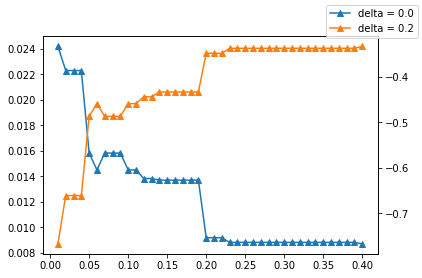

In [54]:
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(np.arange(0.01,0.41,0.01), res_dict[0],'-^', color = 'C0')
ax2.plot(np.arange(0.01,0.41,0.01), res_dict[0.2],'-^', color = 'C1')
#ax2.plot(np.arange(0.01,0.41,0.01), res_dict[0.3],'-^', color = 'C2')
fig.legend(['delta = 0.0','delta = 0.2'])

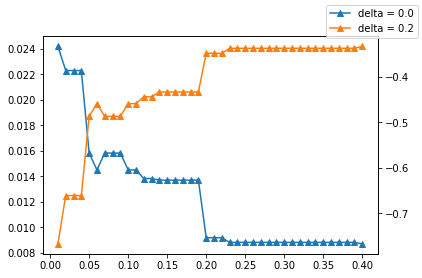

In [55]:
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(np.arange(0.01,0.41,0.01), res_dict[0],'-^', color = 'C0')
ax2.plot(np.arange(0.01,0.41,0.01), res_dict[0.2],'-^', color = 'C1')
#ax2.plot(np.arange(0.01,0.41,0.01), res_dict[0.3],'-^', color = 'C2')
fig.legend(['delta = 0.0','delta = 0.2'])

In [58]:
pd.DataFrame(res_dict).set_index(np.arange(0.01,0.41,0.01))#.to_csv('loss_curve.csv')

,0.0,0.1,0.2,0.3
0.01,0.024206,-0.538517,-0.766962,-0.948536
0.02,0.022299,-0.459683,-0.660640,-0.823053
0.03,0.022299,-0.459683,-0.660640,-0.823053
0.04,0.022299,-0.459683,-0.660640,-0.823053
0.05,0.015822,-0.335050,-0.486697,-0.611341
0.06,0.014496,-0.316516,-0.458620,-0.575254
0.07,0.015822,-0.335050,-0.486697,-0.611341
0.08,0.015822,-0.335050,-0.486697,-0.611341
0.09,0.015822,-0.335050,-0.486697,-0.611341
0.10,0.014496,-0.316516,-0.458620,-0.575254
